# Implementing logistic regression from scratch

The goal of this notebook is to implement your own logistic regression classifier. You will:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Implement the link function for logistic regression.
 * Write a function to compute the derivative of the log likelihood function with respect to a single coefficient.
 * Implement gradient ascent.
 * Given a set of coefficients, predict sentiments.
 * Compute classification accuracy for the logistic regression model.

In [176]:
import pandas as pd
import numpy as np
import json
import string
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline 

## Load review dataset
For this assignment, we will use a subset of the Amazon product review dataset. The subset was chosen to contain **similar numbers** of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

In [4]:
products = pd.read_csv('data_files/amazon_baby_subset.csv')
products.head(2)

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1


In [6]:
print('Number of positive reviews =', len(products[products['sentiment']==1]))
print('Number of negative reviews =', len(products[products['sentiment']==-1]))

Number of positive reviews = 26579
Number of negative reviews = 26493


In [7]:
products.iloc[0:10,]  # list the name of the first 10 products in the dataset

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1


**Note:** For this assignment, we eliminated class imbalance by choosing 
a subset of the data with a similar number of positive and negative reviews.

## Apply text cleaning on the review data

In this section, we will perform some simple feature cleaning. The last assignment used all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). We compiled a list of 193 most frequent words into a JSON file. 

- remove punctuation
- computed word count(only for important words)

Now, we will load these words from this JSON file:

In [8]:
products = products.fillna({'review':''})

In [10]:
import json
with open('data_files/important_words.json') as important_words_file:    
    important_words = json.load(important_words_file)
print (important_words[:10])    # important_words is a list 

['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat']


In [11]:
import string
def remove_punctuation(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    return text

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...


Now we proceed with *Step 2*. For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

In [12]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))   # lambda s  as a defined function

In [13]:
products.head(3)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


count how many reviews contain the word "perfect"

In [14]:
def perfect_count (x):
    if x>=1:
        return 1
    else:
        return 0

In [15]:
products['contain_perfect']=products['perfect'].apply(perfect_count)

In [16]:
np.sum(products['contain_perfect'])

2955

## Convert data frame to NumPy array

As you have seen previously, NumPy is a powerful library for doing matrix manipulation. Let us convert our data to matrices and then implement our algorithms with matrices.
* Input:
    - dataframe: a dataframe to be converted
    - features: a list of strings, containing the names of columns that used as features
    - label: a string, containing the name of the single column that is used as class labels.
* Output:
    - feature_matrix: a 2D array for features
    - label_array: a 1D array for class labels

In [17]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [18]:
feature_matrix, sentiment = get_numpy_data(products, important_words, 'sentiment')  #feature_matrix=important_words columns

In [19]:
print (feature_matrix.shape)

(53072, 194)


## Gradient Ascent

In [102]:
def predict_probability (feature_matrix,coefficients):
    score=np.dot(feature_matrix,coefficients)  # feature_matrix: N*D  coefficients: D*1 score: N*1
    predictions=1.0/(1+np.exp(-score))         #prediction: N*1
    return predictions

In [103]:
### checkpoint for predict_probability:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])

correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),          1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_predictions = np.array( [ 1./(1+np.exp(-correct_scores[0])), 1./(1+np.exp(-correct_scores[1])) ] )

print('The following outputs must match ')
print('------------------------------------------------')
print('correct_predictions           =', correct_predictions)
print('output of predict_probability =', predict_probability(dummy_feature_matrix, dummy_coefficients))

The following outputs must match 
------------------------------------------------
correct_predictions           = [0.98201379 0.26894142]
output of predict_probability = [0.98201379 0.26894142]


In [150]:
def feature_derivative(errors,feature):
    derivative= np.dot(errors, feature)               # errors: N*1, feature: N*1 
    return derivative                                 # derivative: 1*1 dot product

In [127]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment == +1)                     # indicator: N*1
    scores = np.dot(feature_matrix, coefficients)     # scores: N*1
    lp = np.sum(np.multiply(indicator-1,scores) - np.log(1+np.exp(-scores))) # np.multiply: element-wise product; equivalent to: *
    return lp                                         # 1*1: sum of vector elements

In [141]:
### checkpointfor compute_log_likelihood:
dummy_feature_matrix = np.array([[1.,2.,3.], [1.,-1.,-1]])
dummy_coefficients = np.array([1., 3., -1.])
dummy_sentiment = np.array([-1, 1])

correct_indicators  = np.array( [ -1==+1,                                       1==+1 ] )
correct_scores      = np.array( [ 1.*1. + 2.*3. + 3.*(-1.),                     1.*1. + (-1.)*3. + (-1.)*(-1.) ] )
correct_first_term  = np.array( [ (correct_indicators[0]-1)*correct_scores[0],  (correct_indicators[1]-1)*correct_scores[1] ] )
correct_second_term = np.array( [ np.log(1. + np.exp(-correct_scores[0])),      np.log(1. + np.exp(-correct_scores[1])) ] )

correct_ll          =      sum( [ correct_first_term[0]-correct_second_term[0], correct_first_term[1]-correct_second_term[1] ] ) 

print('The following outputs must match ')
print('------------------------------------------------')
print('correct_log_likelihood           =', correct_ll)
print('output of compute_log_likelihood =', compute_log_likelihood(dummy_feature_matrix, dummy_sentiment, dummy_coefficients))

The following outputs must match 
------------------------------------------------
correct_log_likelihood           = -5.331411615436032
output of compute_log_likelihood = -5.331411615436032


In [192]:
from math import sqrt

def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    lp_list = []
    for itr in range(max_iter):
        predictions = predict_probability(feature_matrix, coefficients) # N*1
        indicator = (sentiment==+1)                                     # N*1
        errors = indicator - predictions
       
        for j in range(len(coefficients)): 
            derivative = feature_derivative(errors, feature_matrix[:,j])#1*1
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            lp_list.append(lp)
            print('Iterartion {0}: log likelihood of observed labels = {1:.8f}'.format(itr,lp))
    return (coefficients, lp_list)

In [193]:
initial_coefficients = np.zeros(194)   # set all initial coefficients to 0; dim: 194*1
step_size = 1e-7
max_iter = 301

In [199]:
coefficients = logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter)[0]

Iterartion 0: log likelihood of observed labels = -36780.91768478
Iterartion 1: log likelihood of observed labels = -36775.13434712
Iterartion 2: log likelihood of observed labels = -36769.35713564
Iterartion 3: log likelihood of observed labels = -36763.58603240
Iterartion 4: log likelihood of observed labels = -36757.82101962
Iterartion 5: log likelihood of observed labels = -36752.06207964
Iterartion 6: log likelihood of observed labels = -36746.30919497
Iterartion 7: log likelihood of observed labels = -36740.56234821
Iterartion 8: log likelihood of observed labels = -36734.82152213
Iterartion 9: log likelihood of observed labels = -36729.08669961
Iterartion 10: log likelihood of observed labels = -36723.35786366
Iterartion 11: log likelihood of observed labels = -36717.63499744
Iterartion 12: log likelihood of observed labels = -36711.91808422
Iterartion 13: log likelihood of observed labels = -36706.20710739
Iterartion 14: log likelihood of observed labels = -36700.50205049
Itera

In [202]:
coefficients[:5]

array([ 0.0051622 ,  0.0155657 , -0.00850205,  0.06654608,  0.06589076])

In [203]:
lp_list = logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter)[1]

Iterartion 0: log likelihood of observed labels = -36780.91768478
Iterartion 1: log likelihood of observed labels = -36775.13434712
Iterartion 2: log likelihood of observed labels = -36769.35713564
Iterartion 3: log likelihood of observed labels = -36763.58603240
Iterartion 4: log likelihood of observed labels = -36757.82101962
Iterartion 5: log likelihood of observed labels = -36752.06207964
Iterartion 6: log likelihood of observed labels = -36746.30919497
Iterartion 7: log likelihood of observed labels = -36740.56234821
Iterartion 8: log likelihood of observed labels = -36734.82152213
Iterartion 9: log likelihood of observed labels = -36729.08669961
Iterartion 10: log likelihood of observed labels = -36723.35786366
Iterartion 11: log likelihood of observed labels = -36717.63499744
Iterartion 12: log likelihood of observed labels = -36711.91808422
Iterartion 13: log likelihood of observed labels = -36706.20710739
Iterartion 14: log likelihood of observed labels = -36700.50205049
Itera

In [210]:
lp_list[:5]

[-36780.91768478126,
 -36775.1343471232,
 -36769.3571356369,
 -36763.5860323965,
 -36757.82101961526]

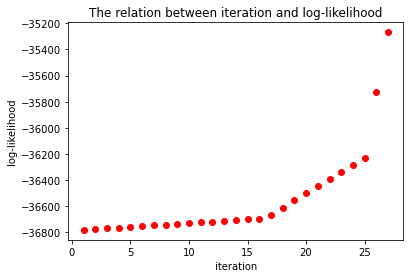

In [211]:
fig,ax = plt.subplots()
ax.scatter(range(1,28), lp_list, color = 'red')
ax.set_title('The relation between iteration and log-likelihood')
ax.set_xlabel('iteration')
ax.set_ylabel('log-likelihood')
plt.show()

## Predicting sentiments and Compute Classification Accuracy
Recall from lecture that class predictions for a data point $\mathbf{x}$ can be computed from the coefficients $\mathbf{w}$ using the following formula:
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{x}_i^T\mathbf{w} > 0 \\
      -1 & \mathbf{x}_i^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

Now, we will write some code to compute class predictions. We will do this in two steps:
* **Step 1**: First compute the **scores** using **feature_matrix** and **coefficients** using a dot product.
* **Step 2**: Using the formula above, compute the class predictions from the scores.

In [212]:
scores = np.dot(feature_matrix,coefficients) #N*D

In [220]:
correct_num = np.sum((scores.flatten()> 0) == (np.array(products['sentiment'])>0))
total_num = len(products['sentiment'])
print ("correct_num: {}, total_num: {}".format(correct_num, total_num))
print ('The accuracy is {0}:'.format(correct_num/total_num))

correct_num: 39903, total_num: 53072
The accuracy is 0.7518653904130238:


## Which words contribute most to positive & negative sentiments?
Recall that in Module 2 assignment, we were able to compute the "**most positive words**". These are words that correspond most strongly with positive reviews. In order to do this, we will first do the following:
* Treat each coefficient as a tuple, i.e. (**word**, **coefficient_value**).
* Sort all the (**word**, **coefficient_value**) tuples by **coefficient_value** in descending order.

In [221]:
coefficients = list(coefficients[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

### Ten "most positive" words

Now, we compute the 10 words that have the most positive coefficient values. These words are associated with positive sentiment.

In [223]:
word_coefficient_tuples[:10]

[('great', 0.06654608417045771),
 ('love', 0.06589076292212326),
 ('easy', 0.0647945868025784),
 ('little', 0.04543562630842137),
 ('loves', 0.04497640139490604),
 ('well', 0.03013500109210707),
 ('perfect', 0.029739937104968462),
 ('old', 0.020077541034775385),
 ('nice', 0.018408707995268992),
 ('daughter', 0.017703199905701694)]

### Ten "most negative" words

Next, we repeat this exercise on the 10 most negative words.  That is, we compute the 10 words that have the most negative coefficient values. These words are associated with negative sentiment.

In [224]:
word_coefficient_tuples[-10:]

[('monitor', -0.024482100545891717),
 ('return', -0.026592778462247283),
 ('back', -0.027742697230661334),
 ('get', -0.028711552980192588),
 ('disappointed', -0.028978976142317068),
 ('even', -0.030051249236035808),
 ('work', -0.03306951529475272),
 ('money', -0.038982037286487116),
 ('product', -0.0415110333921089),
 ('would', -0.05386014844520313)]